In [38]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

In [39]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"]#.iloc[0:1000]
df = df.reset_index()

#jump_inds = range(len(df))
jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()
jump_inds = [x for x in jump_inds]

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_40762/3161146172.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")


In [40]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['delt_d']#'diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in features:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[9566]


In [41]:
data

[{'delt_d': 7.058490337423086},
 {'delt_d': 2.949366262651421},
 {'delt_d': 2.8436805930352316},
 {'delt_d': 2.469534605647331},
 {'delt_d': 1.3976877932807528},
 {'delt_d': 0.7473299673173116},
 {'delt_d': 0.4523739953256062},
 {'delt_d': 0.471644267030592},
 {'delt_d': 0.49584553139087073},
 {'delt_d': 0.788314624793493},
 {'delt_d': -1.2639026574517116},
 {'delt_d': -1.6982854924217083},
 {'delt_d': -1.7373775569502508},
 {'delt_d': -2.0271132767728077},
 {'delt_d': -1.7212306855053385},
 {'delt_d': -1.2549295426542022},
 {'delt_d': -0.5793444017888679},
 {'delt_d': -0.3440235317142952},
 {'delt_d': -0.48893966688687307},
 {'delt_d': -0.5707040060570189},
 {'delt_d': -0.11200700952336351},
 {'delt_d': 0.3630319105039536},
 {'delt_d': -0.47473513371158405},
 {'delt_d': -1.0264312002644116},
 {'delt_d': -1.7232172190641255},
 {'delt_d': -2.062825523033906},
 {'delt_d': -0.47479235150023985},
 {'delt_d': 0.6692939002165144},
 {'delt_d': 0.29492402617109564},
 {'delt_d': 0.0234107454649

# Plot Data

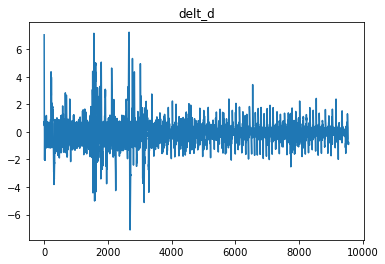

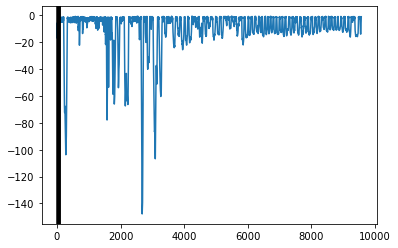

In [42]:
for feature in features:
    plt.plot([datum[feature] for datum in data if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].iloc[0:10000].plot()

for ind in jump_inds:
    if ind < 100:
        plt.axvline(ind,color='k')

# Initialize HMM

In [43]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

K = [2,3]
T = len(data)

### pick distributions ###
features = {'delt_d'     : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : True}}

In [44]:
'''
# shared parameters
share_params = []

# share coarse scale dive duration
for feature in ['delt_d']:
    for param in ['log_mu','log_sig']:
        for k0 in range(K[0]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0],
                                 "K_fine"  :[k1 for k1 in range(K[1])]})

# share fine scale acceleration
for feature in ['aw1','aw2','aw3']:
    for param in ['log_mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
# share autocorrelation for acceleration
for k1 in range(K[1]):
    share_params.append({"features":['aw1','aw2','aw3'],
                         "params"  :['logit_phi'],
                         "K_coarse":[k0 for k0 in range(K[0])],
                         "K_fine"  :[k1]})
            
# share params for "w_low"
for feature in ['w_low']:
    for param in ["mu","log_sig"]:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
'''

# shared parameters
share_params = []

# share coarse scale dive duration
for feature in ['delt_d']:
    for param in ['mu','log_sig']:
        for k0 in range(K[0]):
            for k1 in range(K[1]):
                share_params.append({"features":[feature],
                                     "params"  :[param],
                                     "K_coarse":[k0],
                                     "K_fine"  :[k1]})

In [45]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

K = [2,3]
T = len(data)

### pick distributions ###
features = {'delt_d'     : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : True}}

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,share_params,K)

optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds


optim.theta = [{'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])}},
               {'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])}}]

optim.eta = [array([[ 0. , 0.0],
                    [0.0,  0. ]]),
             [array([[ 0.0  , -0.0  , -100.0],
                     [-100.0, 0.0   , -0.0  ],
                     [0.0, -100.0, 0.0   ]]),
              array([[ 0.0  , -0.0  , -100.0],
                     [-100.0, 0.0   , -0.0  ],
                     [0.0, -100.0, 0.0   ]])]]

optim.eta0 = [array([0.0, 0.0]),
             [array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0])]]


optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
delt_d
{'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}


delt_d
{'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}



initial eta0:
[array([0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[0., 0.],
       [0., 0.]]), [array([[   0.,   -0., -100.],
       [-100.,    0.,   -0.],
       [   0., -100.,    0.]]), array([[   0.,   -0., -100.],
       [-100.,    0.,   -0.],
       [   0., -100.,    0.]])]]



# Define Optimization Parameters

In [46]:
# parse command-line args
max_time = 60*60
id = 1

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

### lipschitz constants ###
if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

method: BFGS
partial E_step: 0.0
random seed: 0
max time : 1.000 hours


# Train the HMM

In [ ]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                               max_time=max_time,
                               method=method,
                               max_epochs=10,
                               partial_E=True,
                               tol=tol,
                               grad_tol=grad_tol,
                               record_like=True,
                               weight_buffer=weight_buffer,
                               grad_buffer=grad_buffer,
                               buffer_eps=1e-3)

initial theta:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]

initial eta0:
[array([0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[0., 0.],
       [0., 0.]]), [array([[   0.,   -0., -100.],
       [-100.,    0.,   -0.],
       [   0., -100.,    0.]]), array([[   0.,   -0., -100.],
       [-100.,    0.,   -0.],
       [   0., -100.,    0.]])]]

parameter bounds:
{'delt_d': {'mu': [-7.115669907903688, 7.243559547513966], 'log_sig': [-5.0, 2.6643929030868994]}}

length of data:
9567

[  -1.    0.    1.   -1.    0.    1.   -1.   -1.   -1.   -1.   -1.   -1.
    0.    0.    0.    0.    0.   -0. -100. -100.    0.   -0.    0. -100.
    0.    0.   -0. -100. -100.    0.   -0.    0. -100.    0.    0.    0.
    0. -100. -100.    0. -100. -100.]
-23827.710325826487
-14850.550150081868
starting epoch 0.0

0.000 hours elapsed

current log-lik

-10361.78234281483
starting epoch 4.0

0.020 hours elapsed

current log-likelihood:
-10361.78234281483

current parameters:
[{'delt_d': {'mu': array([-0.77916478,  0.02985382,  0.81681368]), 'log_sig': array([ 0.38769519, -1.40668052,  0.44579795])}}, {'delt_d': {'mu': array([-0.77916478,  0.02985382,  0.81681368]), 'log_sig': array([ 0.38769519, -1.40668052,  0.44579795])}}]
[array([[ 0.        , -0.08473674],
       [-0.08473674,  0.        ]]), [array([[   0.        ,   -0.20070324, -100.        ],
       [-100.        ,    0.        ,   -0.84947813],
       [  -0.17407554, -100.        ,    0.        ]]), array([[   0.        ,   -0.20070324, -100.        ],
       [-100.        ,    0.        ,   -0.84947813],
       [  -0.17407554, -100.        ,    0.        ]])]]
[array([0., 0.]), [array([   0.        , -100.        ,  -99.99998861]), array([   0.        , -100.        ,  -99.99998861])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 3.71583901

-9251.821000721611
starting epoch 8.0

0.035 hours elapsed

current log-likelihood:
-9251.821000721611

current parameters:
[{'delt_d': {'mu': array([-0.37105761, -0.00665636,  0.48204107]), 'log_sig': array([ 0.60935737, -0.9371889 ,  0.97408853])}}, {'delt_d': {'mu': array([-0.37105761, -0.00665637,  0.48204108]), 'log_sig': array([ 0.60935739, -0.9371889 ,  0.97408857])}}]
[array([[ 0.        , -0.29865857],
       [-0.29865857,  0.        ]]), [array([[   0.        ,   -0.79444256, -100.        ],
       [-100.        ,    0.        ,   -3.03565763],
       [  -0.68291324, -100.        ,    0.        ]]), array([[   0.        ,   -0.79444256, -100.        ],
       [-100.        ,    0.        ,   -3.03565763],
       [  -0.68291324, -100.        ,    0.        ]])]]
[array([0.00000000e+00, 4.52020763e-12]), [array([   0.        , -100.        ,  -99.99999132]), array([   0.        , -100.        ,  -99.99999132])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.

-8946.984496128174
starting epoch 12.0

0.049 hours elapsed

current log-likelihood:
-8946.984496128174

current parameters:
[{'delt_d': {'mu': array([-0.17575295,  0.01677874,  0.38139259]), 'log_sig': array([-0.08266437, -0.99187666,  0.95379571])}}, {'delt_d': {'mu': array([-0.17575302,  0.01677502,  0.38139231]), 'log_sig': array([-0.08266244, -0.99186491,  0.95381458])}}]
[array([[ 0.        , -0.51280402],
       [-0.51280397,  0.        ]]), [array([[   0.        ,   -1.26893773, -100.        ],
       [-100.        ,    0.        ,   -4.22274164],
       [  -1.02585679, -100.        ,    0.        ]]), array([[   0.        ,   -1.26893743, -100.        ],
       [-100.        ,    0.        ,   -4.22274129],
       [  -1.02585963, -100.        ,    0.        ]])]]
[array([0.00000000e+00, 1.34614712e-09]), [array([   0.        , -100.        ,  -99.99997621]), array([   0.        , -100.        ,  -99.99997621])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3

-8739.751371097143
starting epoch 16.0

0.064 hours elapsed

current log-likelihood:
-8739.751371097143

current parameters:
[{'delt_d': {'mu': array([ 0.0714023 , -0.03343962,  0.30536432]), 'log_sig': array([-0.20522468, -1.34587128,  1.00156429])}}, {'delt_d': {'mu': array([ 0.07198827, -0.04025498,  0.30525612]), 'log_sig': array([-0.20678609, -1.34075111,  1.00985755])}}]
[array([[ 0.        , -0.63163521],
       [-0.63161787,  0.        ]]), [array([[   0.        ,   -1.61150947, -100.        ],
       [-100.        ,    0.        ,   -4.70560517],
       [  -1.2416456 , -100.        ,    0.        ]]), array([[   0.        ,   -1.61119789, -100.        ],
       [-100.        ,    0.        ,   -4.70559554],
       [  -1.2425687 , -100.        ,    0.        ]])]]
[array([ 0.00000000e+00, -1.28467427e-06]), [array([   0.        , -100.        ,  -99.99997084]), array([   0.        , -100.        ,  -99.99997084])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18,

-8367.164308119505
starting epoch 20.0

0.084 hours elapsed

current log-likelihood:
-8367.164308119505

current parameters:
[{'delt_d': {'mu': array([0.41347896, 0.03584226, 0.05493323]), 'log_sig': array([-0.26745103, -1.3719646 ,  0.85948776])}}, {'delt_d': {'mu': array([ 0.63424254, -0.32449061,  0.05037462]), 'log_sig': array([-0.41468449, -0.9838565 ,  1.15204296])}}]
[array([[ 0.        , -0.78544449],
       [-0.77443167,  0.        ]]), [array([[   0.        ,   -2.4443073 , -100.        ],
       [-100.        ,    0.        ,   -5.78949044],
       [  -1.70677788, -100.        ,    0.        ]]), array([[   0.        ,   -2.41893797, -100.        ],
       [-100.        ,    0.        ,   -5.79491021],
       [  -1.76282358, -100.        ,    0.        ]])]]
[array([ 0.        , -0.00016961]), [array([   0.        , -100.        ,  -99.99996056]), array([   0.        , -100.        ,  -99.99996056])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901

-7782.723714081077
starting epoch 24.0

0.098 hours elapsed

current log-likelihood:
-7782.723714081077

current parameters:
[{'delt_d': {'mu': array([ 0.1454099 , -0.02078186,  0.08591175]), 'log_sig': array([-0.53824547, -1.5902027 ,  0.11310664])}}, {'delt_d': {'mu': array([ 0.49975841, -0.37920339,  0.17091305]), 'log_sig': array([-0.87176662, -0.76276002,  0.88349596])}}]
[array([[ 0.        , -0.66891474],
       [-0.61350463,  0.        ]]), [array([[   0.        ,   -2.39476292, -100.        ],
       [-100.        ,    0.        ,   -4.61625124],
       [  -1.54405953, -100.        ,    0.        ]]), array([[   0.        ,   -2.32096954, -100.        ],
       [-100.        ,    0.        ,   -4.6498819 ],
       [  -1.67513346, -100.        ,    0.        ]])]]
[array([ 0.        , -0.00062818]), [array([   0.       , -100.       ,  -99.9999509]), array([   0.        , -100.        ,  -99.99994897])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


-7673.497664594511
starting epoch 25.0

0.101 hours elapsed

current log-likelihood:
-7673.497664594511

current parameters:
[{'delt_d': {'mu': array([ 0.13574268, -0.01029171,  0.04207113]), 'log_sig': array([-0.58746992, -1.74765278, -0.09770054])}}, {'delt_d': {'mu': array([ 0.35587921, -0.40126404,  0.23824329]), 'log_sig': array([-0.99840683, -0.88889386,  0.89789044])}}]
[array([[ 0.        , -0.61856627],
       [-0.53094865,  0.        ]]), [array([[   0.        ,   -2.27689507, -100.        ],
       [-100.        ,    0.        ,   -4.04281582],
       [  -1.44897622, -100.        ,    0.        ]]), array([[   0.        ,   -2.17562922, -100.        ],
       [-100.        ,    0.        ,   -4.09472528],
       [  -1.60404554, -100.        ,    0.        ]])]]
[array([ 0.        , -0.00090384]), [array([   0.        , -100.        ,  -99.99994981]), array([   0.       , -100.       ,  -99.9999452])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901

-7016.20560793304
starting epoch 29.0

0.125 hours elapsed

current log-likelihood:
-7016.20560793304

current parameters:
[{'delt_d': {'mu': array([ 0.55236448, -0.01916039, -0.59332001]), 'log_sig': array([-0.70140636, -2.08759032, -0.73603081])}}, {'delt_d': {'mu': array([ 0.22798536, -0.69335988,  0.2719714 ]), 'log_sig': array([-1.41340707, -1.18171986,  1.22720849])}}]
[array([[ 0.        , -0.53428355],
       [-0.30318491,  0.        ]]), [array([[   0.        ,   -2.34434685, -100.        ],
       [-100.        ,    0.        ,   -2.87280593],
       [  -1.4745703 , -100.        ,    0.        ]]), array([[   0.        ,   -2.11946438, -100.        ],
       [-100.        ,    0.        ,   -3.00705168],
       [  -1.73962057, -100.        ,    0.        ]])]]
[array([ 0.       , -0.0017202]), [array([   0.        , -100.        ,  -99.99994259]), array([   0.       , -100.       ,  -99.9993915])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18

-6440.3835691541935
starting epoch 33.0

0.138 hours elapsed

current log-likelihood:
-6440.3835691541935

current parameters:
[{'delt_d': {'mu': array([ 0.6800149 , -0.01053654, -0.77552175]), 'log_sig': array([-0.7529667 , -1.69545568, -0.84414728])}}, {'delt_d': {'mu': array([ 0.19085776, -0.64006677,  0.30745673]), 'log_sig': array([-1.17945766, -1.01353877,  1.08683694])}}]
[array([[ 0.        , -0.40596382],
       [-0.14030876,  0.        ]]), [array([[   0.        ,   -2.07835098, -100.        ],
       [-100.        ,    0.        ,   -2.40413139],
       [  -1.44349524, -100.        ,    0.        ]]), array([[   0.        ,   -1.88763049, -100.        ],
       [-100.        ,    0.        ,   -2.55723858],
       [  -1.70875125, -100.        ,    0.        ]])]]
[array([ 0.        , -0.00197777]), [array([   0.        , -100.        ,  -99.99994237]), array([   0.        , -100.        ,  -99.99901631])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.715

-6356.318025291314
starting epoch 37.0

0.151 hours elapsed

current log-likelihood:
-6356.318025291314

current parameters:
[{'delt_d': {'mu': array([ 0.63761075, -0.01714982, -0.80155204]), 'log_sig': array([-0.90721055, -1.62689529, -0.89975479])}}, {'delt_d': {'mu': array([ 0.21107178, -0.49567253,  0.32045953]), 'log_sig': array([-1.15290933, -1.08455599,  0.97831348])}}]
[array([[ 0.        , -0.33061788],
       [-0.05026743,  0.        ]]), [array([[   0.        ,   -1.85956592, -100.        ],
       [-100.        ,    0.        ,   -2.29865372],
       [  -1.52914478, -100.        ,    0.        ]]), array([[   0.        ,   -1.77474634, -100.        ],
       [-100.        ,    0.        ,   -2.40762374],
       [  -1.75592259, -100.        ,    0.        ]])]]
[array([ 0.        , -0.00174387]), [array([   0.        , -100.        ,  -99.99994028]), array([   0.        , -100.        ,  -99.99813737])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583

-6280.326816899094
starting epoch 41.0

0.165 hours elapsed

current log-likelihood:
-6280.326816899094

current parameters:
[{'delt_d': {'mu': array([ 0.68594023, -0.00479732, -0.76372849]), 'log_sig': array([-0.83061475, -1.6498639 , -0.94947433])}}, {'delt_d': {'mu': array([ 0.28017936, -0.42909655,  0.21507878]), 'log_sig': array([-1.24270788, -1.19322603,  1.05465136])}}]
[array([[ 0.        , -0.17233657],
       [ 0.15839355,  0.        ]]), [array([[   0.        ,   -1.5790672 , -100.        ],
       [-100.        ,    0.        ,   -2.40102607],
       [  -1.87276608, -100.        ,    0.        ]]), array([[   0.        ,   -1.70766293, -100.        ],
       [-100.        ,    0.        ,   -2.37270107],
       [  -2.04766513, -100.        ,    0.        ]])]]
[array([ 0.       , -0.0002451]), [array([   0.       , -100.       ,  -99.9999395]), array([   0.        , -100.        ,  -99.99477084])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-

-6217.24616187781
starting epoch 45.0

0.178 hours elapsed

current log-likelihood:
-6217.24616187781

current parameters:
[{'delt_d': {'mu': array([ 0.69345429, -0.00249773, -0.77789856]), 'log_sig': array([-0.8067617 , -1.61138796, -0.88487879])}}, {'delt_d': {'mu': array([ 0.26010087, -0.46373508,  0.0654036 ]), 'log_sig': array([-1.27892716, -1.12309595,  0.95697528])}}]
[array([[0.        , 0.10584361],
       [0.52252791, 0.        ]]), [array([[   0.        ,   -1.17707296, -100.        ],
       [-100.        ,    0.        ,   -2.51726626],
       [  -2.34618695, -100.        ,    0.        ]]), array([[   0.        ,   -1.53399219, -100.        ],
       [-100.        ,    0.        ,   -2.28670984],
       [  -2.46071926, -100.        ,    0.        ]])]]
[array([0.        , 0.00233962]), [array([   0.       , -100.       ,  -99.9999387]), array([   0.       , -100.       ,  -99.9890654])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 3.715

-6193.699965186901
starting epoch 49.0

0.192 hours elapsed

current log-likelihood:
-6193.699965186901

current parameters:
[{'delt_d': {'mu': array([ 0.66865138, -0.00762329, -0.77045264]), 'log_sig': array([-0.86248939, -1.66516258, -0.89251245])}}, {'delt_d': {'mu': array([ 0.25553891, -0.4973935 , -0.00939192]), 'log_sig': array([-1.16785744, -1.13265027,  1.0000446 ])}}]
[array([[0.        , 0.27778322],
       [0.74580356, 0.        ]]), [array([[   0.        ,   -1.29061415, -100.        ],
       [-100.        ,    0.        ,   -2.52424746],
       [  -2.54608693, -100.        ,    0.        ]]), array([[   0.        ,   -1.52179376, -100.        ],
       [-100.        ,    0.        ,   -2.22694007],
       [  -2.68871734, -100.        ,    0.        ]])]]
[array([0.        , 0.00432489]), [array([   0.        , -100.        ,  -99.99993922]), array([   0.        , -100.        ,  -99.98476806])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6174.73190128256
starting epoch 53.0

0.206 hours elapsed

current log-likelihood:
-6174.73190128256

current parameters:
[{'delt_d': {'mu': array([ 6.91077281e-01,  3.60088043e-04, -7.66026574e-01]), 'log_sig': array([-0.82326309, -1.6258525 , -0.89028836])}}, {'delt_d': {'mu': array([ 0.2440259 , -0.48252069, -0.09058224]), 'log_sig': array([-1.13729016, -1.10091175,  1.00442311])}}]
[array([[0.        , 0.49049231],
       [1.01135617, 0.        ]]), [array([[   0.        ,   -1.37801945, -100.        ],
       [-100.        ,    0.        ,   -2.55427501],
       [  -2.78291355, -100.        ,    0.        ]]), array([[   0.        ,   -1.5194002 , -100.        ],
       [-100.        ,    0.        ,   -2.18348952],
       [  -2.95530458, -100.        ,    0.        ]])]]
[array([0.        , 0.00689098]), [array([   0.       , -100.       ,  -99.9999394]), array([   0.        , -100.        ,  -99.97930768])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.7158

-6167.466605904506
starting epoch 57.0

0.220 hours elapsed

current log-likelihood:
-6167.466605904506

current parameters:
[{'delt_d': {'mu': array([ 0.68314721, -0.00148218, -0.77021453]), 'log_sig': array([-0.79369869, -1.63392514, -0.88030516])}}, {'delt_d': {'mu': array([ 0.24946292, -0.47879859, -0.12332792]), 'log_sig': array([-1.15574358, -1.12074861,  0.99669365])}}]
[array([[0.        , 0.68627314],
       [1.24476804, 0.        ]]), [array([[   0.        ,   -1.56168657, -100.        ],
       [-100.        ,    0.        ,   -2.52806448],
       [  -2.93361923, -100.        ,    0.        ]]), array([[   0.        ,   -1.55902339, -100.        ],
       [-100.        ,    0.        ,   -2.1288394 ],
       [  -3.15926174, -100.        ,    0.        ]])]]
[array([0.        , 0.00975482]), [array([   0.        , -100.        ,  -99.99993935]), array([   0.        , -100.        ,  -99.97334322])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6165.268385001152
starting epoch 61.0

0.234 hours elapsed

current log-likelihood:
-6165.268385001152

current parameters:
[{'delt_d': {'mu': array([ 0.67916676, -0.0041577 , -0.76915048]), 'log_sig': array([-0.81167041, -1.62834705, -0.87365471])}}, {'delt_d': {'mu': array([ 0.24581372, -0.48559926, -0.04841014]), 'log_sig': array([-1.1887088 , -1.16423187,  0.984442  ])}}]
[array([[0.        , 0.69519668],
       [1.23875375, 0.        ]]), [array([[   0.        ,   -1.52969938, -100.        ],
       [-100.        ,    0.        ,   -2.4563464 ],
       [  -2.83167433, -100.        ,    0.        ]]), array([[   0.        ,   -1.54221277, -100.        ],
       [-100.        ,    0.        ,   -2.093015  ],
       [  -3.07988601, -100.        ,    0.        ]])]]
[array([0.        , 0.01057424]), [array([   0.        , -100.        ,  -99.99993947]), array([   0.        , -100.        ,  -99.97173927])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6160.743919410859
starting epoch 65.0

0.247 hours elapsed

current log-likelihood:
-6160.743919410859

current parameters:
[{'delt_d': {'mu': array([ 0.67265685, -0.00620789, -0.77111865]), 'log_sig': array([-0.81677933, -1.6329193 , -0.88795991])}}, {'delt_d': {'mu': array([ 0.24059374, -0.48324508,  0.09154977]), 'log_sig': array([-1.19625841, -1.13348701,  0.99499623])}}]
[array([[0.        , 0.88397611],
       [1.42090789, 0.        ]]), [array([[   0.        ,   -1.52570487, -100.        ],
       [-100.        ,    0.        ,   -2.50811665],
       [  -2.73063636, -100.        ,    0.        ]]), array([[   0.        ,   -1.57103348, -100.        ],
       [-100.        ,    0.        ,   -2.16020297],
       [  -3.08873242, -100.        ,    0.        ]])]]
[array([0.       , 0.0161248]), [array([   0.        , -100.        ,  -99.99993986]), array([   0.       , -100.       ,  -99.9605734])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 3.

-6159.534678340871
starting epoch 69.0

0.261 hours elapsed

current log-likelihood:
-6159.534678340871

current parameters:
[{'delt_d': {'mu': array([ 0.68170471, -0.00260601, -0.77141362]), 'log_sig': array([-0.79685612, -1.63236207, -0.87914083])}}, {'delt_d': {'mu': array([ 0.24611527, -0.48649806,  0.10416987]), 'log_sig': array([-1.162592  , -1.13143079,  0.99534128])}}]
[array([[0.        , 0.9591428 ],
       [1.50394991, 0.        ]]), [array([[   0.        ,   -1.50543397, -100.        ],
       [-100.        ,    0.        ,   -2.52183562],
       [  -2.73919142, -100.        ,    0.        ]]), array([[   0.        ,   -1.56679531, -100.        ],
       [-100.        ,    0.        ,   -2.16801324],
       [  -3.12351907, -100.        ,    0.        ]])]]
[array([0.        , 0.01816703]), [array([   0.        , -100.        ,  -99.99994027]), array([   0.        , -100.        ,  -99.95644079])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6159.199109881706
starting epoch 73.0

0.273 hours elapsed

current log-likelihood:
-6159.199109881706

current parameters:
[{'delt_d': {'mu': array([ 0.68285799, -0.002802  , -0.77295783]), 'log_sig': array([-0.79562947, -1.63355669, -0.87862031])}}, {'delt_d': {'mu': array([ 0.24633622, -0.4854623 ,  0.09157437]), 'log_sig': array([-1.16187432, -1.13409652,  0.9907203 ])}}]
[array([[0.        , 0.95604668],
       [1.50531482, 0.        ]]), [array([[   0.        ,   -1.49965977, -100.        ],
       [-100.        ,    0.        ,   -2.51655817],
       [  -2.70115223, -100.        ,    0.        ]]), array([[   0.        ,   -1.57814092, -100.        ],
       [-100.        ,    0.        ,   -2.19895554],
       [  -3.09395373, -100.        ,    0.        ]])]]
[array([0.        , 0.02001102]), [array([   0.        , -100.        ,  -99.99994016]), array([   0.      , -100.      ,  -99.952754])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 3.7

-6158.646787126608
starting epoch 77.0

0.287 hours elapsed

current log-likelihood:
-6158.646787126608

current parameters:
[{'delt_d': {'mu': array([ 0.68100477, -0.00295416, -0.7722555 ]), 'log_sig': array([-0.79496623, -1.63332325, -0.88116479])}}, {'delt_d': {'mu': array([ 0.24498389, -0.48796712,  0.02718948]), 'log_sig': array([-1.16233831, -1.13499141,  0.99556461])}}]
[array([[0.        , 1.00441082],
       [1.58546999, 0.        ]]), [array([[   0.        ,   -1.49420309, -100.        ],
       [-100.        ,    0.        ,   -2.50660211],
       [  -2.67740016, -100.        ,    0.        ]]), array([[   0.        ,   -1.59844178, -100.        ],
       [-100.        ,    0.        ,   -2.26399594],
       [  -3.09571017, -100.        ,    0.        ]])]]
[array([0.        , 0.02593794]), [array([   0.        , -100.        ,  -99.99993992]), array([   0.        , -100.        ,  -99.94077962])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6158.608312922605
starting epoch 81.0

0.300 hours elapsed

current log-likelihood:
-6158.608312922605

current parameters:
[{'delt_d': {'mu': array([ 0.6809756 , -0.00268866, -0.77102022]), 'log_sig': array([-0.79571788, -1.63412065, -0.87927304])}}, {'delt_d': {'mu': array([ 0.24619702, -0.48651682,  0.03043175]), 'log_sig': array([-1.16266893, -1.12924326,  0.99804397])}}]
[array([[0.        , 1.00335922],
       [1.59004626, 0.        ]]), [array([[   0.        ,   -1.49418642, -100.        ],
       [-100.        ,    0.        ,   -2.49891764],
       [  -2.6845125 , -100.        ,    0.        ]]), array([[   0.        ,   -1.58821683, -100.        ],
       [-100.        ,    0.        ,   -2.25348479],
       [  -3.09925949, -100.        ,    0.        ]])]]
[array([0.        , 0.02658122]), [array([   0.     , -100.     ,  -99.99994]), array([   0.        , -100.        ,  -99.93946363])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 3.7158

-6158.569498220593
starting epoch 85.0

0.313 hours elapsed

current log-likelihood:
-6158.569498220593

current parameters:
[{'delt_d': {'mu': array([ 0.68149984, -0.00273886, -0.77138087]), 'log_sig': array([-0.79528154, -1.63504104, -0.87864107])}}, {'delt_d': {'mu': array([ 0.24743419, -0.48487803,  0.02455441]), 'log_sig': array([-1.16310049, -1.12771011,  0.99698023])}}]
[array([[0.        , 0.99864824],
       [1.60233095, 0.        ]]), [array([[   0.        ,   -1.4934288 , -100.        ],
       [-100.        ,    0.        ,   -2.49507792],
       [  -2.66670363, -100.        ,    0.        ]]), array([[   0.        ,   -1.58297575, -100.        ],
       [-100.        ,    0.        ,   -2.27679617],
       [  -3.08262751, -100.        ,    0.        ]])]]
[array([0.        , 0.02999513]), [array([   0.        , -100.        ,  -99.99993996]), array([   0.        , -100.        ,  -99.93257098])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6158.499556227554
starting epoch 89.0

0.326 hours elapsed

current log-likelihood:
-6158.499556227554

current parameters:
[{'delt_d': {'mu': array([ 0.68100288, -0.00270476, -0.7716133 ]), 'log_sig': array([-0.79420612, -1.63360151, -0.87998885])}}, {'delt_d': {'mu': array([ 0.24900188, -0.48384973,  0.02976618]), 'log_sig': array([-1.16478601, -1.12755079,  0.99738653])}}]
[array([[0.        , 0.98269298],
       [1.62095237, 0.        ]]), [array([[   0.        ,   -1.4988183 , -100.        ],
       [-100.        ,    0.        ,   -2.50172044],
       [  -2.67659655, -100.        ,    0.        ]]), array([[   0.        ,   -1.55680965, -100.        ],
       [-100.        ,    0.        ,   -2.29617196],
       [  -3.08020315, -100.        ,    0.        ]])]]
[array([0.        , 0.03583956]), [array([   0.        , -100.        ,  -99.99993993]), array([   0.        , -100.        ,  -99.92072203])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6158.486370546806
starting epoch 93.0

0.339 hours elapsed

current log-likelihood:
-6158.486370546806

current parameters:
[{'delt_d': {'mu': array([ 0.68087309, -0.00264629, -0.77129608]), 'log_sig': array([-0.79443492, -1.63346709, -0.87975574])}}, {'delt_d': {'mu': array([ 0.24865167, -0.48432366,  0.03353144]), 'log_sig': array([-1.16452266, -1.1272907 ,  0.99807623])}}]
[array([[0.        , 0.98026827],
       [1.62103796, 0.        ]]), [array([[   0.        ,   -1.49821923, -100.        ],
       [-100.        ,    0.        ,   -2.50060682],
       [  -2.68473779, -100.        ,    0.        ]]), array([[   0.        ,   -1.56073211, -100.        ],
       [-100.        ,    0.        ,   -2.28723211],
       [  -3.0859096 , -100.        ,    0.        ]])]]
[array([0.        , 0.03656166]), [array([   0.        , -100.        ,  -99.99993996]), array([   0.        , -100.        ,  -99.91923433])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6158.441217345517
starting epoch 97.0

0.352 hours elapsed

current log-likelihood:
-6158.441217345517

current parameters:
[{'delt_d': {'mu': array([ 0.68106096, -0.00258455, -0.77121339]), 'log_sig': array([-0.79383735, -1.63331225, -0.87939065])}}, {'delt_d': {'mu': array([ 0.2486029 , -0.48499524,  0.03951054]), 'log_sig': array([-1.16362437, -1.12707779,  0.99836909])}}]
[array([[0.        , 0.95653056],
       [1.65428726, 0.        ]]), [array([[   0.        ,   -1.4956462 , -100.        ],
       [-100.        ,    0.        ,   -2.49708449],
       [  -2.69389956, -100.        ,    0.        ]]), array([[   0.        ,   -1.57149433, -100.        ],
       [-100.        ,    0.        ,   -2.30154854],
       [  -3.08397238, -100.        ,    0.        ]])]]
[array([0.        , 0.04940213]), [array([   0.        , -100.        ,  -99.99993998]), array([   0.        , -100.        ,  -99.89313002])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-1

-6158.436181633092
starting epoch 101.0

0.365 hours elapsed

current log-likelihood:
-6158.436181633092

current parameters:
[{'delt_d': {'mu': array([ 0.6811583 , -0.00263946, -0.7714898 ]), 'log_sig': array([-0.79365069, -1.63339503, -0.87961664])}}, {'delt_d': {'mu': array([ 0.24892006, -0.48459414,  0.03630337]), 'log_sig': array([-1.16393245, -1.12738882,  0.99777364])}}]
[array([[0.        , 0.95733241],
       [1.65577558, 0.        ]]), [array([[   0.        ,   -1.49619757, -100.        ],
       [-100.        ,    0.        ,   -2.49822439],
       [  -2.68637805, -100.        ,    0.        ]]), array([[   0.        ,   -1.56789181, -100.        ],
       [-100.        ,    0.        ,   -2.30862773],
       [  -3.07908056, -100.        ,    0.        ]])]]
[array([0.        , 0.05023614]), [array([   0.        , -100.        ,  -99.99993995]), array([   0.        , -100.        ,  -99.89143861])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-

-6158.406405641273
starting epoch 105.0

0.378 hours elapsed

current log-likelihood:
-6158.406405641273

current parameters:
[{'delt_d': {'mu': array([ 0.68116873, -0.00274676, -0.77183782]), 'log_sig': array([-0.79373005, -1.63329654, -0.88001583])}}, {'delt_d': {'mu': array([ 0.24930662, -0.48402478,  0.03048698]), 'log_sig': array([-1.16513493, -1.12870774,  0.99710046])}}]
[array([[0.        , 0.95324706],
       [1.65965185, 0.        ]]), [array([[   0.        ,   -1.49703457, -100.        ],
       [-100.        ,    0.        ,   -2.50157424],
       [  -2.66996782, -100.        ,    0.        ]]), array([[   0.        ,   -1.56171996, -100.        ],
       [-100.        ,    0.        ,   -2.2999648 ],
       [  -3.07614484, -100.        ,    0.        ]])]]
[array([0.        , 0.06226367]), [array([   0.        , -100.        ,  -99.99993992]), array([   0.        , -100.        ,  -99.86683494])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-

-6158.35638444246
starting epoch 109.0

0.601 hours elapsed

current log-likelihood:
-6158.35638444246

current parameters:
[{'delt_d': {'mu': array([ 0.68099276, -0.00281757, -0.77182721]), 'log_sig': array([-0.79406763, -1.6326876 , -0.88008258])}}, {'delt_d': {'mu': array([ 0.24929352, -0.48425254,  0.02969178]), 'log_sig': array([-1.16667919, -1.13096976,  0.99743001])}}]
[array([[0.        , 0.92476322],
       [1.69031177, 0.        ]]), [array([[   0.        ,   -1.49568718, -100.        ],
       [-100.        ,    0.        ,   -2.50420403],
       [  -2.65755293, -100.        ,    0.        ]]), array([[   0.        ,   -1.56466635, -100.        ],
       [-100.        ,    0.        ,   -2.26602248],
       [  -3.08343461, -100.        ,    0.        ]])]]
[array([0.       , 0.1011264]), [array([   0.        , -100.        ,  -99.99993996]), array([   0.        , -100.        ,  -99.78739207])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18, 

-6158.34707457682
starting epoch 113.0

0.662 hours elapsed

current log-likelihood:
-6158.34707457682

current parameters:
[{'delt_d': {'mu': array([ 0.68099214, -0.00274494, -0.77159627]), 'log_sig': array([-0.79401795, -1.63275114, -0.87982672])}}, {'delt_d': {'mu': array([ 0.24904265, -0.48461412,  0.0335828 ]), 'log_sig': array([-1.1658953 , -1.13011017,  0.99786405])}}]
[array([[0.        , 0.92704071],
       [1.68767404, 0.        ]]), [array([[   0.        ,   -1.49509675, -100.        ],
       [-100.        ,    0.        ,   -2.50188755],
       [  -2.66739112, -100.        ,    0.        ]]), array([[   0.        ,   -1.56868645, -100.        ],
       [-100.        ,    0.        ,   -2.27171491],
       [  -3.08630273, -100.        ,    0.        ]])]]
[array([0.        , 0.09828296]), [array([   0.        , -100.        ,  -99.99993997]), array([   0.        , -100.        ,  -99.79314854])]]

current prior means:
[{'delt_d': {'mu': array([3.71583901e-18, 3.71583901e-18

# Save the HMM

In [ ]:
optim.theta

In [ ]:
date_today = datetime.today().strftime('%Y-%m-%d')

In [ ]:
file = "case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/case_study/updown/"):
    os.mkdir("../params/case_study/updown/")
    
if not os.path.isdir("../params/case_study/updown/" + date_today):
    os.mkdir("../params/case_study/updown/" + date_today)

with open("../params/case_study/updown/" + date_today + "/" + file, 'wb') as f:
    pickle.dump(optim, f)

In [ ]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[0]['delt_d']['mu'])
    y.append(theta[1]['delt_d']['log_sig'])
    
plt.plot(x)
plt.plot(y)

In [ ]:
x = []
y = []
for eta in optim.eta_trace:
    x.append(eta[0].flatten())
    #y.append(eta[1])
    
plt.plot(x)
#plt.plot(y)

In [ ]:
self = optim

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]*self.K[0]
perc = 0.95

fig,ax = plt.subplots(1,len(self.features)+1,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)",
            "delt_d"       : "Change in Depth"}

for fignum,feature in enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for fignum,k0 in enumerate(range(self.K[0])):
        for k1 in range(self.K[1]):

            # define state:
            state = fignum*self.K[1] + k1
            
            # plot distribution
            ax[fignum].plot(x,y0[:,state],
                            color=fine_colors[k1])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
    #ax[fignum].set_xscale('log')
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

# Unit Tests

In [17]:
optim.E_step()

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


In [18]:
delta = 0.0001

ll0 = optim.get_log_like()

optim.eta[1][1][2,0] += delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

ll1 = optim.get_log_like()

optim.eta[1][1][2,0] -= delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

print((ll1 - ll0) / delta)

print(optim.grad_eta[1][1][2,0])

-0.0028934630336152622
-0.0010812133416621772


In [19]:
optim.grad_eta

[array([[ 0.        ,  0.00102834],
        [-0.00020122,  0.        ]]),
 [array([[ 0.00000000e+00, -1.60850113e-03,  1.60590900e-40],
         [ 4.46761733e-37,  0.00000000e+00,  2.30121386e-03],
         [-7.43888697e-04,  6.10497436e-43,  0.00000000e+00]]),
  array([[ 0.00000000e+00,  3.81486304e-04, -6.70977466e-42],
         [-2.92279778e-42,  0.00000000e+00, -7.16120173e-04],
         [-1.08121334e-03, -1.96058224e-42,  0.00000000e+00]])]]